In [1]:
# !pip install arcgis

In [2]:
"""Plague Classification Model with ArcGIS Data"""

import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from arcgis.gis import GIS
from PIL import Image
import logging
import time
from concurrent.futures import ThreadPoolExecutor, as_completed


C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Parámetros de la red
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000
LEARNING_RATE = 0.001


images_dir = '../last_data'

In [4]:
# Cargar dataset de imágenes
train_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    shuffle=True
)

validation_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

Found 4308 files belonging to 5 classes.
Using 3447 files for training.
Found 4308 files belonging to 5 classes.
Using 861 files for validation.


In [5]:
# Paso 1: Filtrar el dataset por cada clase usando tf.reduce_any para obtener un tensor booleano escalar
chinche_salivosa_ds = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 0)))
clororis_ds = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 1)))
hoja_sana_ds = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 2)))
roya_naranja_ds = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 3)))
roya_purpura_ds = train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 4)))

# Paso 2: Contar ejemplos manualmente
def count_examples(dataset):
    return dataset.reduce(0, lambda x, _: x + 1).numpy()

# Obtener el tamaño de la clase mayoritaria
chinche_salivosa_size = count_examples(chinche_salivosa_ds)
clororis_size = count_examples(clororis_ds)
hoja_sana_size = count_examples(hoja_sana_ds)
roya_naranja_size = count_examples(roya_naranja_ds)
roya_purpura_size = count_examples(roya_purpura_ds)

majority_class_size = max(
    chinche_salivosa_size,
    clororis_size,
    hoja_sana_size,
    roya_naranja_size,
    roya_purpura_size
)

# Paso 3: Sobremuestrear las clases minoritarias
chinche_salivosa_ds = chinche_salivosa_ds.repeat().take(majority_class_size)
clororis_ds = clororis_ds.repeat().take(majority_class_size)
hoja_sana_ds = hoja_sana_ds.repeat().take(majority_class_size)
roya_naranja_ds = roya_naranja_ds.repeat().take(majority_class_size)
roya_purpura_ds = roya_purpura_ds.repeat().take(majority_class_size)

# Paso 4: Concatenar los datasets sobremuestreados
oversampled_train_ds = chinche_salivosa_ds.concatenate(clororis_ds)
oversampled_train_ds = oversampled_train_ds.concatenate(hoja_sana_ds)
oversampled_train_ds = oversampled_train_ds.concatenate(roya_naranja_ds)
oversampled_train_ds = oversampled_train_ds.concatenate(roya_purpura_ds)

# Paso 5: Aplicar las operaciones de optimización de cache y prefetch
oversampled_train_ds = oversampled_train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [6]:
# Paso 6: Verificar la nueva distribución de clases
# Filtrar el dataset final por clase para contar los ejemplos nuevamente
oversampled_chinche_salivosa_ds = oversampled_train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 0)))
oversampled_clororis_ds = oversampled_train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 1)))
oversampled_hoja_sana_ds = oversampled_train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 2)))
oversampled_roya_naranja_ds = oversampled_train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 3)))
oversampled_roya_purpura_ds = oversampled_train_ds.filter(lambda x, y: tf.reduce_any(tf.equal(y, 4)))

# Contar la cantidad de ejemplos en cada clase
oversampled_chinche_salivosa_size = count_examples(oversampled_chinche_salivosa_ds)
oversampled_clororis_size = count_examples(oversampled_clororis_ds)
oversampled_hoja_sana_size = count_examples(oversampled_hoja_sana_ds)
oversampled_roya_naranja_size = count_examples(oversampled_roya_naranja_ds)
oversampled_roya_purpura_size = count_examples(oversampled_roya_purpura_ds)

# Mostrar la distribución de clases final
print(f"Nueva distribución de clases después del sobremuestreo:")
print(f"Chinche salivosa: {oversampled_chinche_salivosa_size}")
print(f"Clororis: {oversampled_clororis_size}")
print(f"Hoja sana: {oversampled_hoja_sana_size}")
print(f"Roya naranja: {oversampled_roya_naranja_size}")
print(f"Roya purpura: {oversampled_roya_purpura_size}")

Nueva distribución de clases después del sobremuestreo:
Chinche salivosa: 539
Clororis: 533
Hoja sana: 540
Roya naranja: 540
Roya purpura: 540


In [7]:
# # Data Augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomContrast(0.1),
# ])

In [8]:
# augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
class_names = train_ds.class_names

In [10]:
# # Primero, contamos cuántos ejemplos tiene cada clase
# class_counts = train_ds.reduce(
#     tf.constant([0, 0, 0, 0, 0], dtype=tf.int64), 
#     lambda counts, batch: counts + tf.cast(tf.math.bincount(batch[1], minlength=5), dtype=tf.int64)
# )

In [11]:

# # Obtenemos el número máximo de ejemplos
# max_count = tf.reduce_max(class_counts).numpy()

In [12]:
# # Función para aplicar augmentación a las clases minoritarias
# def augment_minority_class(x, y):
#     augmented_x = x
#     # Convertimos y a int32 para asegurar que funcione bien en TensorFlow
#     y_int = tf.cast(y, tf.int32)
    
#     # Usamos tf.gather para obtener los valores de class_counts correspondientes a las etiquetas
#     class_count_for_y = tf.gather(class_counts, y_int)
    
#     # Aplicamos augmentación si el número de ejemplos para la clase es menor al máximo
#     should_augment = tf.less(class_count_for_y, max_count)
    
#     # Si should_augment es True, aplica augmentación; si no, deja la imagen como está
#     augmented_x = tf.cond(tf.reduce_any(should_augment), lambda: data_augmentation(x, training=True), lambda: x)

#     return augmented_x, y



In [13]:

# # Aplicamos data augmentation a las clases minoritarias
# augmented_train_ds = train_ds.map(lambda x, y: augment_minority_class(x, y))



In [14]:
# # Finalmente, seguimos con el procesamiento normal de cache y prefetch
# augmented_train_ds = augmented_train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# # Cache y prefetch para mejorar rendimiento
# train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Cargar el modelo base (MobileNetV2) 
from tensorflow.keras.applications import MobileNetV2


# Cargar el modelo base (MobileNetV2)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [17]:
# Ajuste de las capas del modelo base
for layer in base_model.layers[:100]:  # Ajusta según sea necesario
    layer.trainable = False

In [18]:

# Definir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Aumentar dropout
    tf.keras.layers.Dense(len(class_names))
])


In [19]:
# Compilar el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

In [20]:
# Elimina el lr_schedule y usa un valor fijo para la tasa de aprendizaje
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),  # tasa de aprendizaje fija
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
import tensorflow as tf

# Verificar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Se encontraron {len(gpus)} GPU(s): {gpus}")
else:
    print("No se encontró ninguna GPU, TensorFlow usará la CPU.")


No se encontró ninguna GPU, TensorFlow usará la CPU.


: 

In [47]:
# Callbacks para early stopping y reducción del learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Entrenamiento del modelo
history = model.fit(
    oversampled_train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]  # Añadir callbacks
)


Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 158s 267ms/step - accuracy: 0.7857 - loss: 1.4063 - val_accuracy: 0.7189 - val_loss: 1.7545 - learning_rate: 0.0010
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 147s 271ms/step - accuracy: 0.9353 - loss: 0.2904 - val_accuracy: 0.4576 - val_loss: 8.6605 - learning_rate: 0.0010
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - accuracy: 0.9614 - loss: 0.1779 - val_accuracy: 0.8455 - val_loss: 1.1821 - learning_rate: 0.0010
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.9713 - loss: 0.1405 - val_accuracy: 0.6655 - val_loss: 3.1938 - learning_rate: 0.0010
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 140s 259ms/step - accuracy: 0.9828 - loss: 0.1046 - val_accuracy: 0.7863 - val_loss: 2.0298 - learning_rate: 0.0010
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.9836 - loss: 0.1014 - val_accuracy: 0.7329 - val_loss: 3.7291 - learning_rate: 0.0010
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accura

In [48]:
# Guardar el modelo en formato .keras
model.save('final_model.keras')

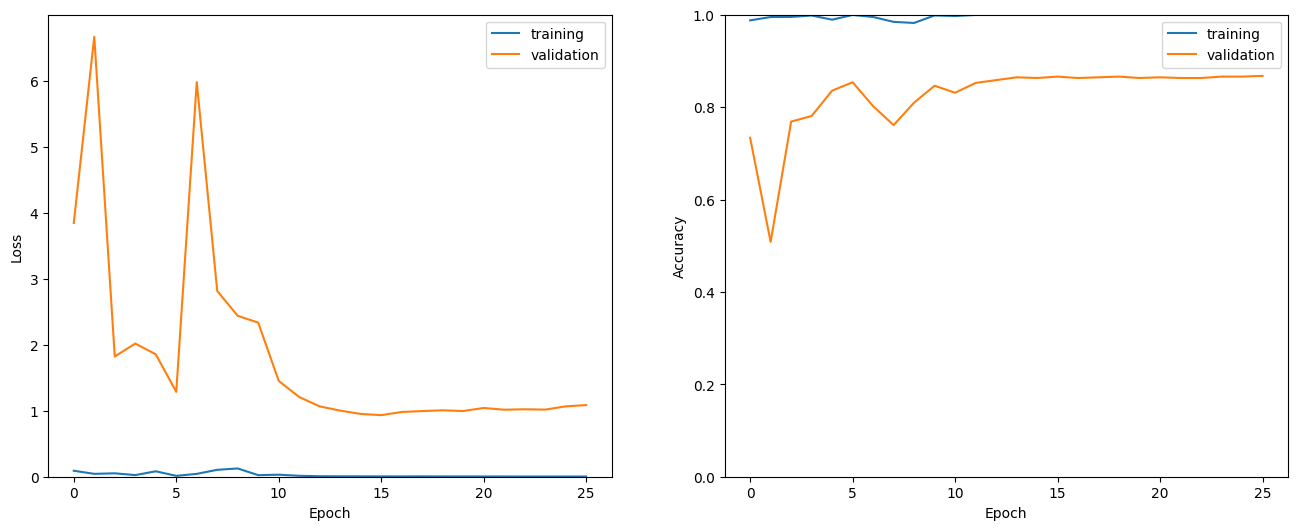

In [49]:
# Gráfica de la pérdida y precisión
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [50]:
# Evaluación en el conjunto de test
test_ds = validation_ds.shard(num_shards=2, index=1)
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8888 - loss: 0.7988
Resultados de evaluación en test set:
accuracy: 0.8844
loss: 0.8063


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step


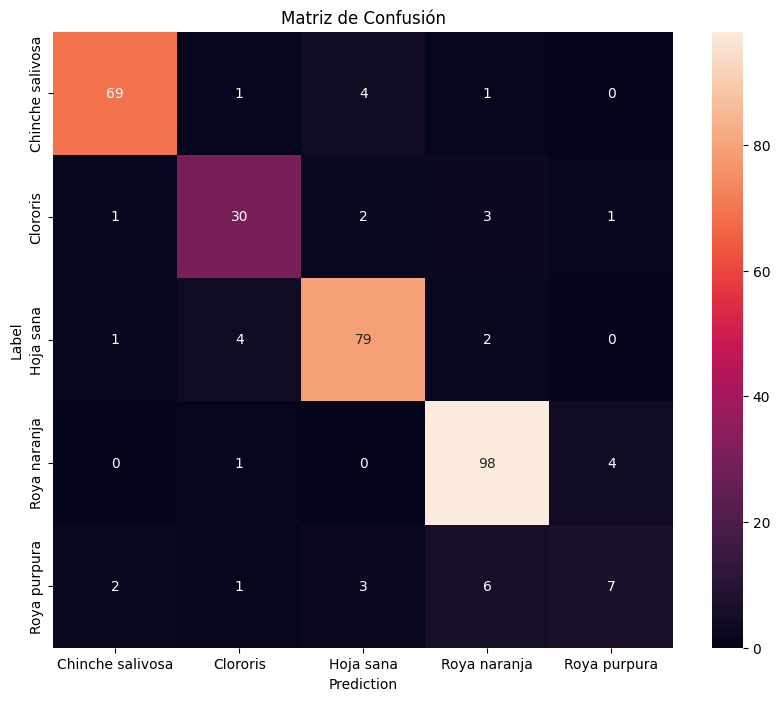

In [51]:
# Matriz de confusión
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Matriz de Confusión')
plt.show()


In [25]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.93      0.88      0.90        75
        Clororis       0.86      0.81      0.83        37
       Hoja sana       0.83      0.93      0.88        86
    Roya naranja       0.87      0.93      0.90       103
    Roya purpura       0.75      0.32      0.44        19

        accuracy                           0.87       320
       macro avg       0.85      0.77      0.79       320
    weighted avg       0.87      0.87      0.86       320

